# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from sklearn.linear_model import LinearRegression

# Data

In [2]:
data = pd.read_csv('data/clean_weather.csv', index_col=0)
data = data.ffill()

In [3]:
data.head(5)

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


In [4]:
data.shape

(13509, 4)

# Linear regression intuition

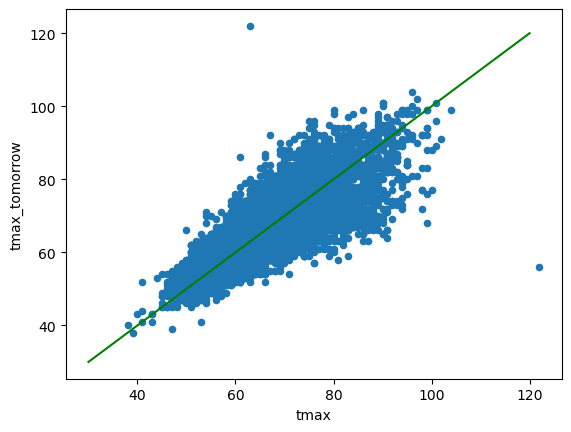

In [7]:
data.plot.scatter('tmax', 'tmax_tomorrow')
plt.plot([30, 120], [30, 120], 'green')

$\hat {y} = w_{1} * x_{1} + b$

$\hat {y} = w_{1} * x_{1} + w_{2} * x_{2} + b$

In [11]:
lr = LinearRegression() # initialize linear regression class
lr.fit(data[['tmax']], data['tmax_tomorrow'])

LinearRegression()

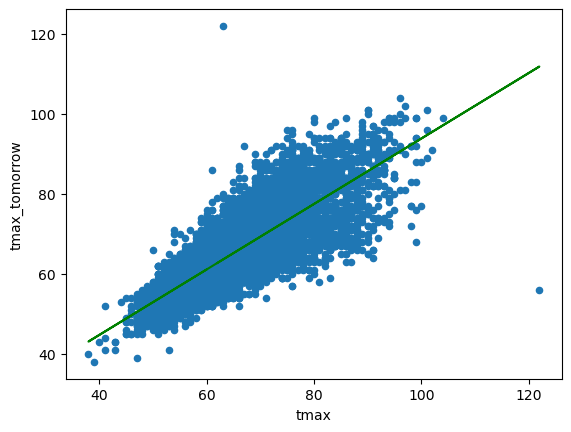

In [14]:
data.plot.scatter('tmax', 'tmax_tomorrow')
plt.plot(data['tmax'], lr.predict(data[['tmax']]), 'green')

In [15]:
print(f'Weight: {lr.coef_[0]:.2f}')
print(f'Bias: {lr.intercept_:.2f}')

Weight: 0.82
Bias: 11.99


# Measuring loss

$MSE=(\hat{y} - y) ^ 2$ - loss function for linear regression

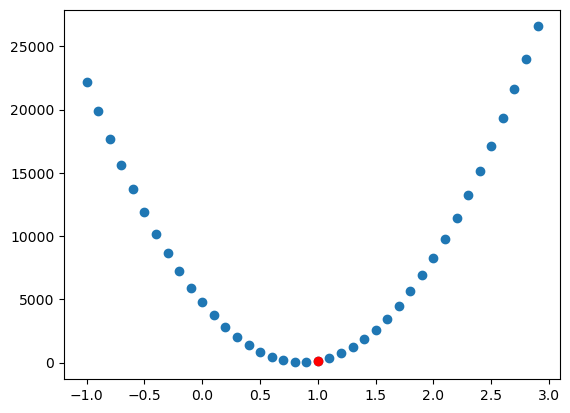

In [23]:
# for tmax = 80, tmax_tomorrow = 81 and bias 11.99 calculate every loss for weights in range from -1 to 3 with step 0.1

loss = lambda w, y: ((w * 80 + 11.99) - y) ** 2
y = 81

ws = np.arange(-1, 3, .1)
losses = loss(ws, y)
plt.scatter(ws, losses)
plt.plot(1, loss(1, y), 'ro') # plot red dot for weigth 1

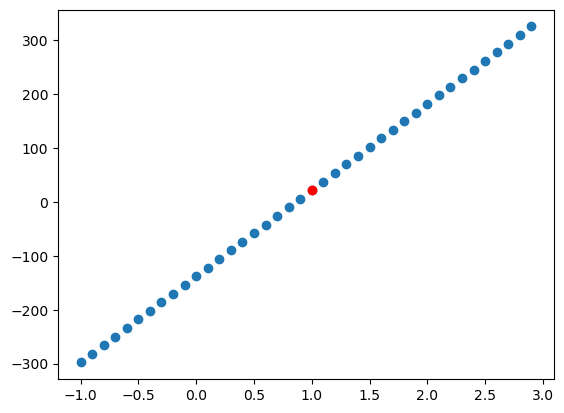

In [25]:
# gradient tells us how quickly the loss is changing as the weights change (the rate of change of the loss)
# the derivative of the loss function
gradient = lambda w, y: ((w * 80 + 11.99) - y) * 2
gradients = gradient(ws, y)

plt.scatter(ws, gradients)
plt.plot(1, gradient(1, y), 'ro') # in this case the gradient is a line

In [ ]:
# What the gradient descent is trying to do is to reach the point where the gradient is 0
# This is where the loss is the lowest
# But it's not always the case (sometimes you can reach local minimum (not global minimum))

# Gradients and Partial Derivatives

In [27]:
# for w=1 and b=11.99
1 * 80 + 11.99 # prediction

91.99

In [28]:
(((1 * 80) + 11.99) - 81) * 2 # gradient (derivative of the loss function)

21.97999999999999

In [ ]:
# If I want to reduce the error, If I want to make the prediction closer to the real value
# how do I need to change b and w?

$\frac{\partial L}{\partial b}={\partial L}$ - gradient of b with respect to the loss

$\frac{\partial L}{\partial w}=\frac{\partial L}{\partial (w*x)}\frac{\partial (w*x)}{\partial w}$ - gradient of w with respect to the loss (the chain rule for derivatives)

In [29]:
# b
21.98

21.98

In [30]:
# w
21.98 * 80

1758.4

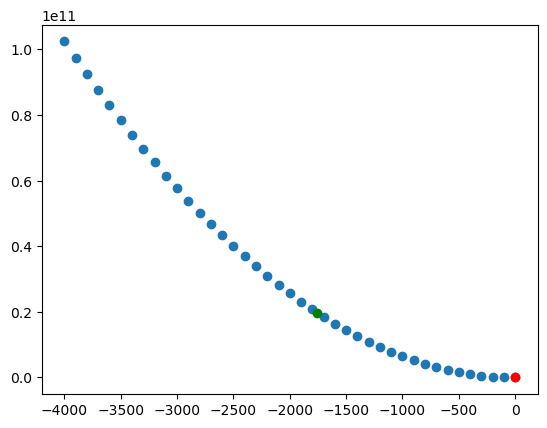

In [34]:
ws = np.arange(-4000, 100, 100)
losses = loss(ws, y)

plt.scatter(ws, losses)
plt.plot(1, loss(1, y), 'ro')
new_weight = 1 - gradient(1, y) * 80 # parameter update
plt.plot(new_weight, loss(new_weight, y), 'go')

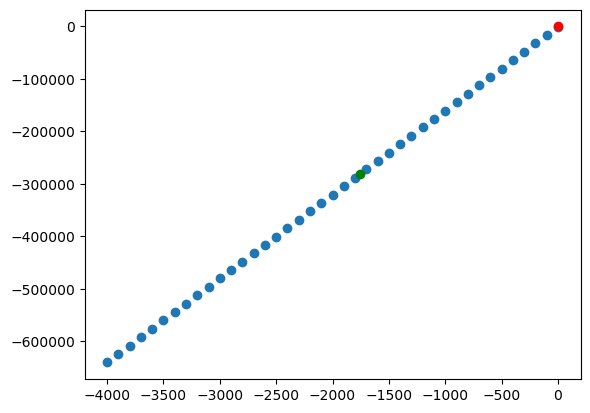

In [36]:
gradients = gradient(ws, y)

plt.scatter(ws, gradients)
plt.plot(1, gradient(1, y), 'ro')
plt.plot(new_weight, gradient(new_weight, y), 'go')

# Learning Rate

In [ ]:
# Learning rate reduces the size of the learning rate, so we don't take too large of a step

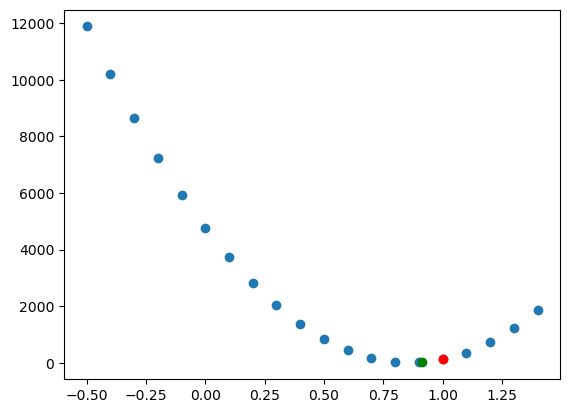

In [38]:
ws = np.arange(-0.5, 1.5, 0.1)
losses = loss(ws, y)

plt.scatter(ws, losses)

plt.plot(1, loss(1, y), 'ro')
lr = 5e-5
new_weight = 1 - lr * gradient(1, y) * 80 # parameter update with learning rate
plt.plot(new_weight, loss(new_weight, y), 'go')

In [39]:
new_weight

0.91208

In [42]:
# before we used a single data point to calculate the gradient and then update parameters
# now we will use all of the data
# So what we actually do
# 1. Calculate the error for each training example
# 2. Basically average the gradient and update w and b parameters

# So we find the average error across all the data and we will update the parameters to reduce the average error
# And this will fit the entire dataset except 1 training example

# It's something called BATCH GRADIENT DESCENT
# But for NN it's more common to use a STOCHASTIC GRADIENT DESCENT

# The differnce is that instead of averaging the gradient across all of the data we either 
# just take a single training example and train one example at the time, or take a very small set of examples (like 30)
# and then compute the gradient and make an update using that small batch

# Implement Linear Regression

In [59]:
PREDICTORS = ['tmax', 'tmin', 'rain']
TARGET = 'tmax_tomorrow'

np.random.seed(0)
split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))]) # split the data into 3 sets
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = \
(
    [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]
)

/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [60]:
# train set for training our algorithm
# validation set to measure how well the algorithm is doing as we are training it
# test set for the final evaluation (need a final evaluation in order to avoid overfitting)

In [61]:
# to buid the algorithm we need 4 pieces
# 1. We need a way to initialize our weights and biases 
# (so we need initial guess about what the correct weight and bias is, so the algorithm can start iterating)
# 2. We need to write a function that makes predictions
# 3. We need to write a function that measures the loss and gradients
# 4. We need a backward pass that will update the parameters based on our loss

In [62]:
# because we have 3 predictors we need to initialize 3 weights and 1 bias
def init_params(predictors):
    np.random.seed(0)

    weights = np.random.rand(predictors, 1) # random initialization between 0 and 1 for weights matrix with 1 column
    biases = np.ones((1, 1)) # one bias in this case (with linear regression we can predict multiple targets, 
                             # and if we have multiple targets, so we need multiple biases)
    return [weights, biases]

In [63]:
def forward(params, x):
    weights, biases = params
    prediction = x @ weights + biases # w1 * tmax + w2 * tmain + w3 * rain + b
    return prediction

In [64]:
# calculate loss
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2) # we calculate MSE across the dataset, because we work with multiple datapoints

# calculate gradient
def mse_grad(actual, predicted):
    return predicted - actual # we can multiply it by 2 but without it we have a little bit more flexibility

In [67]:
def backward(params, x, lr, grad):
    # x1 * g, x2 * g, x3 * g
    w_grad = (x.T / x.shape[0]) @ grad # we get one value for each of our weights that we can use to update the weights
                                    # the reason we devide by x.shape[0] is because we use BATCH GRADIENT DESCENT
                                    # we want to average our entire dataset before we make updates
    b_grad = np.mean(grad, axis=0) # axis=0 is just averaging across all of our training data

    params[0] -= w_grad * lr
    params[1] -= b_grad * lr

    return params

# Training Loop

In [73]:
# if lr is too high, then loss will be inf (then nan), if lr is too low, then the algo will not learn
# lr = 1e-2
lr = 1e-8
# lr = 1e-4
epochs = 500

params = init_params(train_x.shape[1])

for epoch in range(epochs):
    predictions = forward(params, train_x)
    grad = mse_grad(train_y, predictions)
    
    params = backward(params, train_x, lr, grad)

    if epoch % 100 == 0:
        predictions = forward(params, valid_x)
        valid_loss = mse(valid_y, predictions)

        print(f'Epoch {epoch} loss: {valid_loss}')

Epoch 0 loss: 75.72232163752099
Epoch 100 loss: 74.9912267947528
Epoch 200 loss: 74.27095360138428
Epoch 300 loss: 73.56134825109672
Epoch 400 loss: 72.86225908259257


In [74]:
params

[array([[0.54634379],
        [0.71321918],
        [0.60276097]]),
 array([[0.99996264]])]

In [ ]:
# The area for experiments
# 1. Try different learning rates
# 2. Try different weights initialization
#    a. weights = np.random.rand(predictors, 1) / 2
#    b. weights = np.random.rand(predictors, 1) - 0.5 (it will reschale from -0.5 to 0.5)
# 3. Add a regularization (ridge) term 
#    (add additional parameter to the update which would be a function of the original weight
#    and that would make so that your weights don't get too large)